# Feature Engineering and Modeling

In [1]:
import arff

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import fastai.tabular.all as fai

## Load data

In [2]:
freq_data = arff.load('data/freMTPL2freq.arff')
freq_df = pd.DataFrame(
    freq_data, 
    columns=[
        "IDpol", 
        "ClaimNb", 
        "Exposure", 
        "Area", 
        "VehPower",
        "VehAge",
        "DrivAge", 
        "BonusMalus", 
        "VehBrand", 
        "VehGas", 
        "Density", 
        "Region"
    ]
)

In [3]:
freq_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,5.0,1.0,0.75000,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,10.0,1.0,0.09000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,11.0,1.0,0.84000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93'
678009,6114327.0,0.0,0.00274,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11'
678010,6114328.0,0.0,0.00274,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82'
678011,6114329.0,0.0,0.00274,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26'


In [4]:
sev_data = arff.load('data/freMTPL2sev.arff')
sev_df = pd.DataFrame(sev_data, columns=["IDpol", "ClaimAmount"])

In [5]:
sev_df

,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00
...,...,...
26634,3254353.0,1200.00
26635,3254353.0,1800.00
26636,3254353.0,1000.00
26637,2222064.0,767.55


## Feature engineering

Some points should be mentioned here about the plan.
1. There are a lot of samples in the dataset that do not have non-zero claims amounts. 
    1. I think this would disturb the model to replace the dependent variable for these samples with zero.
    1. As was found in the exploratory analysis, it seems like the distribution of the two populations are almost identical.
    1. The rest of the work will exclude the null ClaimAmount samples.
1. We may have to deal with some issues with the dependent variable
    1. The span is over many orders of magnitude and it is not distributed evenly so it was decided to work with the log.
    1. Some outliers will simply be thrown out.
    1. There are 2 small peaks in the distribution that may call for being dealt with.
1. The correlation of the features to the target are very weak.
    1. I think this calls for a more flexible model.
    1. I'll even try some flexible feature engineering on the categorical variables that will also serve the purpose of trying out another model.

### One-hot encoding of the categorical data

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [7]:
cont_vars, cat_vars = fai.cont_cat_split(freq_df)

In [8]:
enc = OneHotEncoder()
enc.fit(freq_df[cat_vars])
enc.categories_

[array(["'A'", "'B'", "'C'", "'D'", "'E'", "'F'"], dtype=object),
 array(["'B1'", "'B10'", "'B11'", "'B12'", "'B13'", "'B14'", "'B2'",
        "'B3'", "'B4'", "'B5'", "'B6'"], dtype=object),
 array(['Diesel', 'Regular'], dtype=object),
 array(["'R11'", "'R21'", "'R22'", "'R23'", "'R24'", "'R25'", "'R26'",
        "'R31'", "'R41'", "'R42'", "'R43'", "'R52'", "'R53'", "'R54'",
        "'R72'", "'R73'", "'R74'", "'R82'", "'R83'", "'R91'", "'R93'",
        "'R94'"], dtype=object)]

In [9]:
cat_enc_df = pd.DataFrame(
    enc.transform(freq_df[cat_vars]).toarray(), 
    columns=enc.get_feature_names_out(cat_vars), 
)
cat_enc_df

,Area_'A',Area_'B',Area_'C',Area_'D',Area_'E',Area_'F',VehBrand_'B1',VehBrand_'B10',VehBrand_'B11',VehBrand_'B12',...,Region_'R53',Region_'R54',Region_'R72',Region_'R73',Region_'R74',Region_'R82',Region_'R83',Region_'R91',Region_'R93',Region_'R94'
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
678009,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
678010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
678011,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate logYearCost and remove samples where null
For experimentation purposes, make a version of the data with the one-hot encoding of categorical values and another without. This is being done because the intent below is to try an XGBoost regressor which can also handle categorical variables.

In [10]:
sev_agg_df = pd.DataFrame(
    sev_df.groupby('IDpol')['ClaimAmount'].sum()
).reset_index()
sev_agg_df

,IDpol,ClaimAmount
0,139.0,303.00
1,190.0,1981.84
2,414.0,1456.55
3,424.0,10834.00
4,463.0,3986.67
...,...,...
24945,6113521.0,1324.40
24946,6113793.0,1769.88
24947,6113817.0,1288.28
24948,6113834.0,12230.40


In [11]:
claim_df = pd.concat([freq_df[cont_vars], cat_enc_df], axis=1)
claim_df = pd.merge(claim_df, sev_agg_df, how='left', on='IDpol')
claim_df['YearCost'] = claim_df['ClaimAmount']/claim_df['Exposure']
claim_df = claim_df.drop(['Exposure', 'ClaimAmount'], axis=1)
claim_df

,IDpol,ClaimNb,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_'A',Area_'B',Area_'C',...,Region_'R54',Region_'R72',Region_'R73',Region_'R74',Region_'R82',Region_'R83',Region_'R91',Region_'R93',Region_'R94',YearCost
0,1.0,1.0,5.0,0.0,55.0,50.0,1217.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,3.0,1.0,5.0,0.0,55.0,50.0,1217.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
2,5.0,1.0,6.0,2.0,52.0,50.0,54.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,10.0,1.0,7.0,0.0,46.0,50.0,76.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,11.0,1.0,7.0,0.0,46.0,50.0,76.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,4.0,0.0,54.0,50.0,3317.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
678009,6114327.0,0.0,4.0,0.0,41.0,95.0,9850.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
678010,6114328.0,0.0,6.0,2.0,45.0,50.0,1323.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
678011,6114329.0,0.0,4.0,0.0,60.0,50.0,95.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [12]:
null_cost = claim_df['YearCost'].isna()

In [13]:
def log_col(df, col):
    """
    Convert a column of a dataframe to its log.
    """
    out_df = df.copy()
    out_df = out_df.rename({col: f"log{col}"}, axis=1)
    out_df.loc[~out_df[f"log{col}"].isna(), f"log{col}"] = (
        np.log(out_df.loc[~out_df[f"log{col}"].isna(), f"log{col}"])
    )
    return out_df

In [14]:
log_claim_df = log_col(claim_df, 'YearCost')
log_claim_df[~null_cost]

,IDpol,ClaimNb,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_'A',Area_'B',Area_'C',...,Region_'R54',Region_'R72',Region_'R73',Region_'R74',Region_'R82',Region_'R83',Region_'R91',Region_'R93',Region_'R94',logYearCost
66,139.0,1.0,7.0,1.0,61.0,50.0,27000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.001415
93,190.0,1.0,12.0,5.0,50.0,60.0,56.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.557894
199,414.0,1.0,4.0,0.0,36.0,85.0,4792.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.249939
205,424.0,2.0,10.0,0.0,51.0,100.0,27000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.768480
223,463.0,1.0,5.0,0.0,45.0,50.0,12.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.461895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677203,6113521.0,1.0,4.0,1.0,26.0,60.0,311.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.903513
677475,6113793.0,1.0,7.0,2.0,51.0,50.0,178.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.444780
677499,6113817.0,1.0,4.0,0.0,35.0,51.0,1719.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.933020
677516,6113834.0,2.0,15.0,3.0,36.0,50.0,181.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.183637


In [15]:
claim_cont_cat_df = pd.merge(freq_df, sev_agg_df, how='left', on='IDpol') 
claim_cont_cat_df['YearCost'] = (
    claim_cont_cat_df['ClaimAmount']/claim_cont_cat_df['Exposure']
)
claim_cont_cat_df = claim_cont_cat_df.drop(['Exposure', 'ClaimAmount'], axis=1)
log_claim_cont_cat_df = log_col(claim_cont_cat_df, 'YearCost')
log_claim_cont_cat_df.loc[:, cat_vars] = (
    log_claim_cont_cat_df[cat_vars].astype('category')
)
log_claim_cont_cat_nonull_df = log_claim_cont_cat_df.loc[~null_cost, :]
log_claim_cont_cat_nonull_df.loc[:, cat_vars] = (
    log_claim_cont_cat_nonull_df[cat_vars].astype('category')
)
log_claim_cont_cat_nonull_df

,IDpol,ClaimNb,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,logYearCost
66,139.0,1.0,'F',7.0,1.0,61.0,50.0,'B12',Regular,27000.0,'R11',6.001415
93,190.0,1.0,'B',12.0,5.0,50.0,60.0,'B12',Diesel,56.0,'R25',9.557894
199,414.0,1.0,'E',4.0,0.0,36.0,85.0,'B12',Regular,4792.0,'R11',9.249939
205,424.0,2.0,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',9.768480
223,463.0,1.0,'A',5.0,0.0,45.0,50.0,'B12',Regular,12.0,'R73',9.461895
...,...,...,...,...,...,...,...,...,...,...,...,...
677203,6113521.0,1.0,'C',4.0,1.0,26.0,60.0,'B12',Diesel,311.0,'R82',8.903513
677475,6113793.0,1.0,'C',7.0,2.0,51.0,50.0,'B12',Diesel,178.0,'R72',9.444780
677499,6113817.0,1.0,'D',4.0,0.0,35.0,51.0,'B12',Regular,1719.0,'R82',8.933020
677516,6113834.0,2.0,'C',15.0,3.0,36.0,50.0,'B12',Regular,181.0,'R54',11.183637


In [16]:
cont_vars.remove('Exposure')

## Experiment with some modeling
At this point I think it makes sense to experiment with some modeling to help decide how to proceed. As was mentioned before, I think something rather flexible would help a lot so as to decrease the load on the manual feature engineering. This was motivated by the poor correlation between all of the features and the target variable. I chose to go with XGBoost for investigation. In the meantime, I quickly tried a linear regression and a K-nearest-neighbor model with no improvement.

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, KFold

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

### Prepare fitting inputs

Here the outliers mentioned before are being thrown out.

In [18]:
log_claim_low_thresh = 0
log_claim_high_thresh = 15.5

In [19]:
sample_select = (
    (
        log_claim_cont_cat_nonull_df['logYearCost'] 
        > log_claim_low_thresh
    )
    & (
        log_claim_cont_cat_nonull_df['logYearCost'] 
        <= log_claim_high_thresh
    )
)

Two versions of the dataset, with categorical and with one-hot encoding, will be played with hear with switches to go back and forth between them.

In [20]:
scaler = MinMaxScaler()
features_cont_cat_nonull_df = (
    log_claim_cont_cat_nonull_df
        .loc[sample_select, :]
        .set_index('IDpol')
        .drop('logYearCost', axis=1)
)
features_cont_cat_nonull_df[cat_vars] = (
    features_cont_cat_nonull_df[cat_vars]
        .astype('category')
)
features_cont_nonull = (
    scaler.fit_transform(
        features_cont_cat_nonull_df[[
            var for var in cont_vars if var != 'IDpol'
        ]]
    )
)
features_cont_cat_nonull_df.loc[:, [
    var for var in cont_vars if var != 'IDpol'
]] = features_cont_nonull
features_cont_cat_nonull_df

,ClaimNb,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
IDpol,,,,,,,,,,
139.0,0.000000,'F',0.272727,0.010101,0.530864,0.000000,'B12',Regular,1.000000,'R11'
190.0,0.000000,'B',0.727273,0.050505,0.395062,0.056180,'B12',Diesel,0.002000,'R25'
414.0,0.000000,'E',0.000000,0.000000,0.222222,0.196629,'B12',Regular,0.177421,'R11'
424.0,0.066667,'F',0.545455,0.000000,0.407407,0.280899,'B12',Regular,1.000000,'R11'
463.0,0.000000,'A',0.090909,0.000000,0.333333,0.000000,'B12',Regular,0.000370,'R73'
...,...,...,...,...,...,...,...,...,...,...
6113521.0,0.000000,'C',0.000000,0.010101,0.098765,0.056180,'B12',Diesel,0.011445,'R82'
6113793.0,0.000000,'C',0.272727,0.020202,0.407407,0.000000,'B12',Diesel,0.006519,'R72'
6113817.0,0.000000,'D',0.000000,0.000000,0.209877,0.005618,'B12',Regular,0.063597,'R82'


In [21]:
scaler = MinMaxScaler()
log_claim_nonull_df = log_claim_df.loc[~null_cost, :]
features_nonull_df = (
    log_claim_nonull_df
        .loc[sample_select, :]
        .set_index('IDpol')
        .drop('logYearCost', axis=1)
)
features_nonull = scaler.fit_transform(features_nonull_df)
features_nonull_df = pd.DataFrame(
    features_nonull, 
    columns=features_nonull_df.columns, 
    index=features_nonull_df.index, 
)
features_nonull_df

,ClaimNb,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_'A',Area_'B',Area_'C',Area_'D',...,Region_'R53',Region_'R54',Region_'R72',Region_'R73',Region_'R74',Region_'R82',Region_'R83',Region_'R91',Region_'R93',Region_'R94'
IDpol,,,,,,,,,,,,,,,,,,,,,
139.0,0.000000,0.272727,0.010101,0.530864,0.000000,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190.0,0.000000,0.727273,0.050505,0.395062,0.056180,0.002000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414.0,0.000000,0.000000,0.000000,0.222222,0.196629,0.177421,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424.0,0.066667,0.545455,0.000000,0.407407,0.280899,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
463.0,0.000000,0.090909,0.000000,0.333333,0.000000,0.000370,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6113521.0,0.000000,0.000000,0.010101,0.098765,0.056180,0.011445,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6113793.0,0.000000,0.272727,0.020202,0.407407,0.000000,0.006519,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6113817.0,0.000000,0.000000,0.000000,0.209877,0.005618,0.063597,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [22]:
# Prepare dependent variable
log_claim_amount_nonull_df = (
    log_claim_cont_cat_nonull_df[['IDpol', 'logYearCost']]
        .loc[
            sample_select, 
            :, 
        ]
        .set_index('IDpol')
)
log_claim_amount_nonull_df

,logYearCost
IDpol,
139.0,6.001415
190.0,9.557894
414.0,9.249939
424.0,9.768480
463.0,9.461895
...,...
6113521.0,8.903513
6113793.0,9.444780
6113817.0,8.933020


### Setup model

In [23]:
WITH_CATEGORICAL = 1
XGBOOST = 1

In [24]:
X_df = (
    features_cont_cat_nonull_df if WITH_CATEGORICAL
    else features_nonull_df
)
y_df = log_claim_amount_nonull_df

I suspect that there will be a lot of outliers to protect against so I decided to choose an absolute error objective. The parameters used for XGBoost here have been played with by hand.

In [25]:
objective = 'reg:absoluteerror'
eval_metric = 'rmse'
enable_categorical = True if WITH_CATEGORICAL else False

In [26]:
model = XGBRegressor(
    n_estimators=100, 
    eta=0.3, # 0.3
    gamma=1, # 0
    max_depth=6, # 6
    max_leaves=10, 
    min_child_weight=20, # 1
    subsample=0.5, # 1
    reg_lambda=10, # 1 (L2)
    reg_alpha=2, # 0 (L1)
    grow_policy='depthwise', # depthwise
    tree_method='hist', # auto
    max_bin=16, # 256
    random_state=0, 
    enable_categorical=enable_categorical, 
    objective=objective, 
    eval_metric=eval_metric, 
) if XGBOOST else KNeighborsRegressor() # LinearRegression()

### Cross-validation

In [27]:
cv_iterator = KFold(
    n_splits=10, 
    shuffle=True, 
    random_state=0, 
)

In [28]:
cv_results = cross_validate(
    model, 
    X_df, 
    y_df, 
    scoring=[
        'neg_root_mean_squared_error', 
        'neg_median_absolute_error', 
    ], 
    cv=cv_iterator, 
    return_estimator=True, 
)

In [29]:
print(
    "Average test_neg_root_mean_squared_error"
    f" = {cv_results['test_neg_root_mean_squared_error'].mean()}"
)
print(
    "Average test_neg_median_absolute_error"
    f" = {cv_results['test_neg_median_absolute_error'].mean()}"
)

Average test_neg_root_mean_squared_error = -1.3867217912830683
Average test_neg_median_absolute_error = -0.5768223243107388


### Plot results

In [30]:
def plot_regression(
        X_df, 
        y_df, 
        fold, 
        i_data, 
        cv_results,
        ax,  
        sort_by_pred=True, 
        col=None, 
        **kwargs, 
    ):
    X_data_df = X_df.iloc[i_data]
    y_pred_df = pd.DataFrame(
        cv_results['estimator'][fold]
            .predict(X_data_df)
            .flatten(), 
        columns=['prediction'], 
        index=X_data_df.index
    )
    y_data_df = y_df.iloc[i_data]
    y_fold_df = pd.concat([y_data_df, y_pred_df], axis=1)
    X_y_fold_df = pd.concat([X_data_df, y_fold_df], axis=1)
    sort_col = 'prediction' if sort_by_pred else 'logYearCost'
    if col is None:
        y_fold_df = y_fold_df.sort_values(sort_col)
        ax.plot(
            y_fold_df['logYearCost'].to_numpy(), 
            marker='.',
            linestyle='', 
            label='logYearCost', 
        )
        ax.plot(y_fold_df['prediction'].to_numpy(), label='prediction')
    else:
        X_y_fold_df = X_y_fold_df.sort_values(col)
        ax.plot(
            X_y_fold_df[col].to_numpy(), 
            X_y_fold_df['logYearCost'].to_numpy(), 
            marker='.',
            linestyle='', 
            label='logYearCost', 
        )
        ax.plot(
            X_y_fold_df[col].to_numpy(), 
            X_y_fold_df['prediction'].to_numpy(), 
            label='prediction'
        )
        ax.set_xlabel(col)
    ax.legend()
    _ = ax.set(**kwargs)

I chose two ways of visualizing the fits. The first is to simple order the sample in increasing prediction and plot the targets surrounding them. The second is to plot the dependent variable as a function of each of the independent variables (further below).

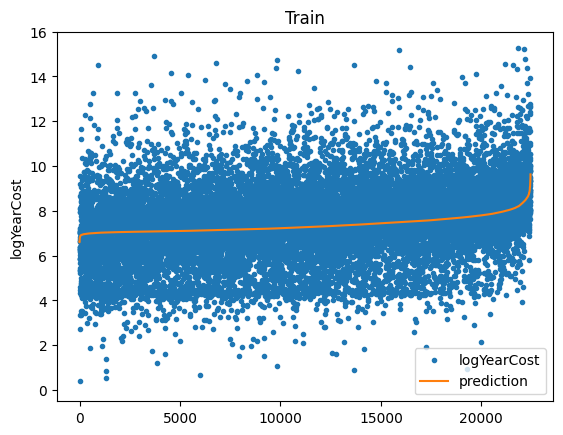

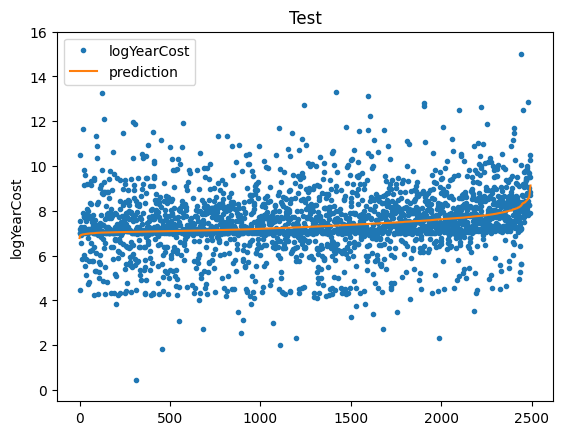

In [31]:
fold = 0
ylim = [-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5]
sort_by_pred = True
for fold_i, (train_i, test_i) in enumerate(
    cv_iterator.split(X_df, y_df)
):
    if fold_i==fold:
        fig_train, ax_train = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            train_i, 
            cv_results, 
            ax_train, 
            sort_by_pred=sort_by_pred, 
            ylabel='logYearCost', 
            ylim=ylim, 
            title='Train', 
        )
        fig_test, ax_test = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            test_i, 
            cv_results, 
            ax_test, 
            sort_by_pred=sort_by_pred, 
            ylabel='logYearCost', 
            ylim=ylim, 
            title='Test', 
        )        

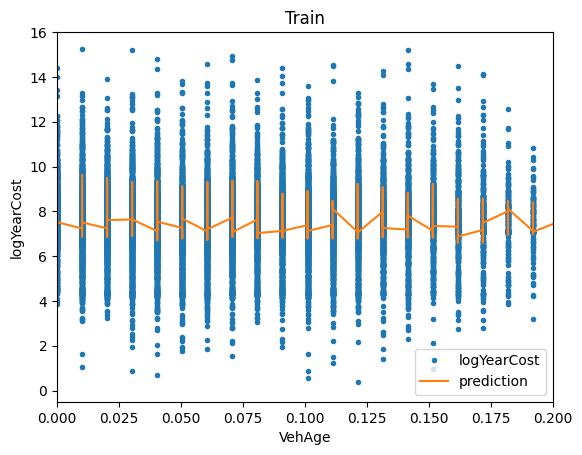

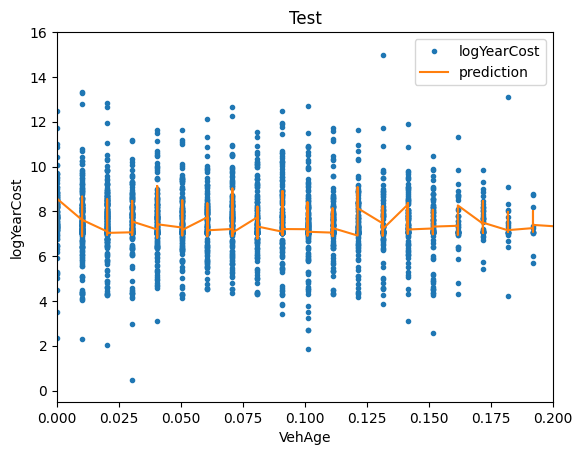

In [32]:
fold = 0
ylim = [-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5]
xlim = [0, .2]
sort_by_pred = True
col = "VehAge"
for fold_i, (train_i, test_i) in enumerate(
    cv_iterator.split(X_df, y_df)
):
    if fold_i==fold:
        fig_train, ax_train = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            train_i, 
            cv_results, 
            ax_train, 
            sort_by_pred=sort_by_pred, 
            col=col, 
            ylabel='logYearCost', 
            ylim=ylim, 
            xlim=xlim, 
            title='Train', 
        )
        fig_test, ax_test = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            test_i, 
            cv_results, 
            ax_test, 
            sort_by_pred=sort_by_pred, 
            col=col, 
            ylabel='logYearCost', 
            xlim=xlim, 
            ylim=ylim, 
            title='Test', 
        )        

As seen below, this is a pretty common pattern as the data is quite discreet. This begs the question of whether there is correlation between the orange and blue data points along each line. To do this, we pull out a pair of lines and carry out similar plots as above where we sort according to the prediction and plot the target over that.

In [33]:
def construct_fold_X_y_df(
    X_df, 
    y_df, 
    fold, 
    cv_iterator, 
    cv_results, 
    train=False, 
): 
    """
    Construct a dataframe with the predictions and targets for a given CV-fold.
    """
    i_train, i_test = list(cv_iterator.split(X_df, y_df))[fold]
    i_data = i_train if train else i_test
    X_data_df = X_df.iloc[i_data]
    y_pred_df = pd.DataFrame(
        cv_results['estimator'][fold]
            .predict(X_data_df)
            .flatten(), 
        columns=['prediction'], 
        index=X_data_df.index
    )
    y_data_df = y_df.iloc[i_data]
    X_y_fold_df = pd.concat([X_data_df, y_data_df, y_pred_df], axis=1)
    return X_y_fold_df

In [34]:
X_y_test0_df = construct_fold_X_y_df(
    X_df, y_df, 0, cv_iterator, cv_results, train=False, 
)
X_y_test0_01VehAge_df = X_y_test0_df.loc[(X_y_test0_df['VehAge'] > 0.095) & (X_y_test0_df['VehAge'] <= 0.11)]
X_y_test0_01VehAge_df

,ClaimNb,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,logYearCost,prediction
IDpol,,,,,,,,,,,,
17850.0,0.000000,'C',0.000000,0.10101,0.395062,0.000000,'B1',Diesel,0.009223,'R25',4.820174,7.036105
20001.0,0.000000,'A',0.363636,0.10101,0.382716,0.000000,'B10',Regular,0.000370,'R24',9.911084,7.126735
37656.0,0.000000,'C',0.000000,0.10101,0.222222,0.067416,'B2',Diesel,0.017631,'R41',6.008322,7.088839
39642.0,0.000000,'B',0.181818,0.10101,0.432099,0.000000,'B1',Diesel,0.001778,'R82',8.129168,7.135113
40413.0,0.000000,'D',0.545455,0.10101,0.333333,0.117978,'B5',Diesel,0.027521,'R82',7.028308,7.171259
...,...,...,...,...,...,...,...,...,...,...,...,...
5067594.0,0.000000,'D',0.090909,0.10101,0.370370,0.000000,'B1',Regular,0.070116,'R31',7.421909,7.255632
5083898.0,0.066667,'A',0.181818,0.10101,0.049383,0.224719,'B1',Diesel,0.001185,'R83',7.431279,8.053108
6060081.0,0.000000,'D',0.090909,0.10101,0.098765,0.123596,'B4',Diesel,0.020853,'R93',5.843829,7.316324


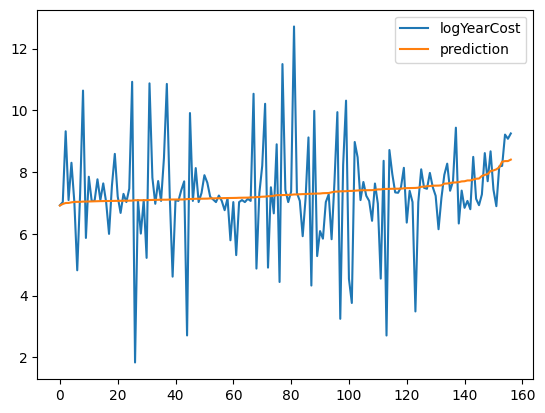

In [35]:
ax = (
    X_y_test0_01VehAge_df
        .sort_values('prediction')
        .reset_index()
        .plot(y=['logYearCost', 'prediction'])
)

In [36]:
X_y_test0_012VehAge_df = X_y_test0_df.loc[(X_y_test0_df['VehAge'] > 0.119) & (X_y_test0_df['VehAge'] <= 0.122)]
X_y_test0_012VehAge_df

,ClaimNb,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,logYearCost,prediction
IDpol,,,,,,,,,,,,
22044.0,0.0,'C',0.090909,0.121212,0.543210,0.000000,'B3',Diesel,0.014705,'R24',7.028308,7.147620
39732.0,0.0,'D',0.090909,0.121212,0.135802,0.168539,'B4',Diesel,0.056782,'R72',4.409520,7.613959
39826.0,0.0,'D',0.454545,0.121212,0.197531,0.022472,'B1',Regular,0.072413,'R11',6.807017,7.245053
44799.0,0.0,'E',0.272727,0.121212,0.518519,0.000000,'B5',Diesel,0.344655,'R82',11.633478,6.948503
46886.0,0.0,'C',0.000000,0.121212,0.197531,0.421348,'B2',Regular,0.004667,'R24',8.925262,7.145041
...,...,...,...,...,...,...,...,...,...,...,...,...
4171601.0,0.0,'D',0.000000,0.121212,0.864198,0.000000,'B5',Regular,0.043707,'R82',7.093405,7.024570
4179513.0,0.0,'C',0.272727,0.121212,0.271605,0.095506,'B2',Diesel,0.005445,'R24',8.604654,7.086155
4179866.0,0.0,'E',0.272727,0.121212,0.222222,0.067416,'B4',Regular,0.142603,'R11',7.166941,7.263412


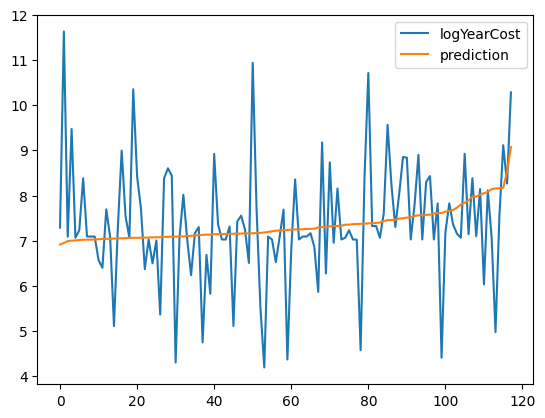

In [37]:
ax = (
    X_y_test0_012VehAge_df
        .sort_values('prediction')
        .reset_index()
        .plot(y=['logYearCost', 'prediction'])
)

The above two plots look like there is quite some good correlation along those data points so it looks like the model is doing a good job following the data that isn't outliers.

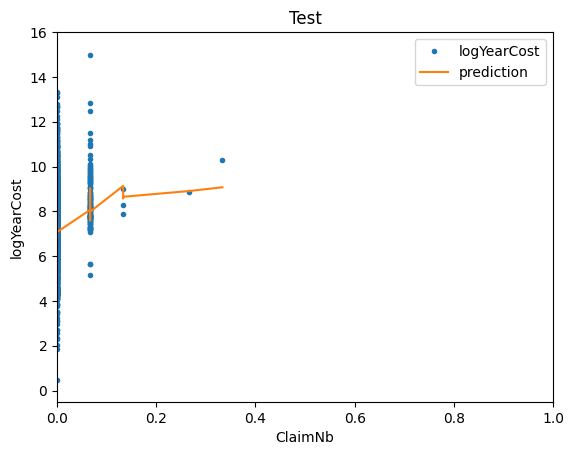

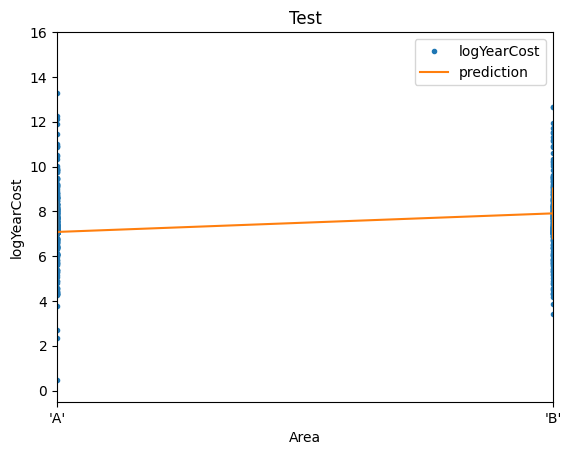

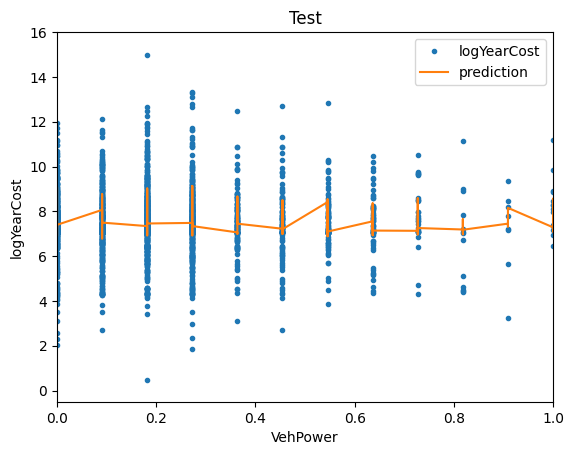

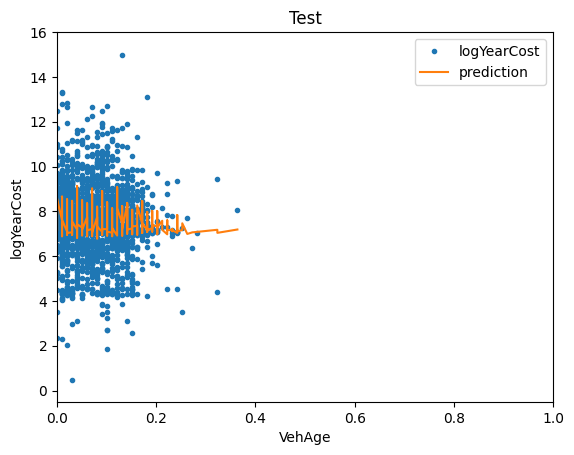

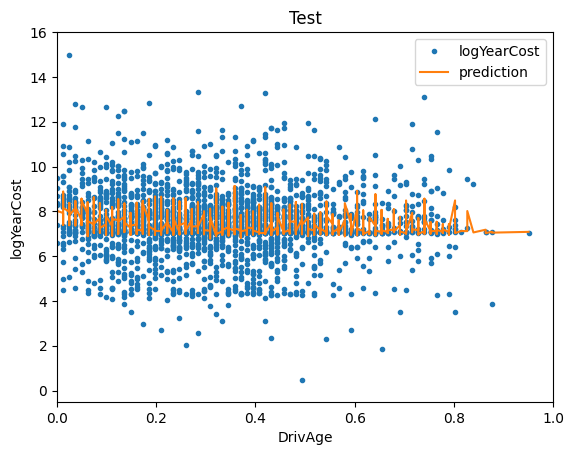

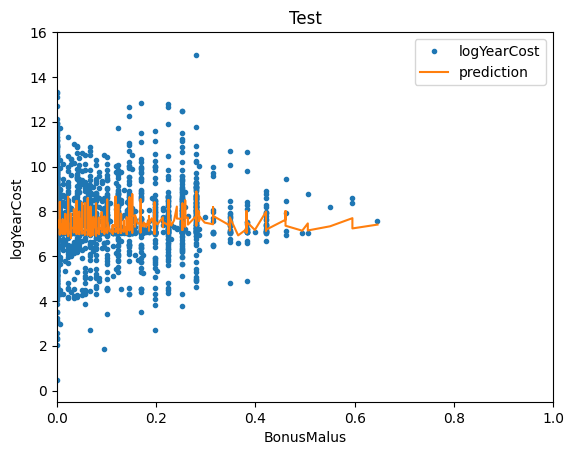

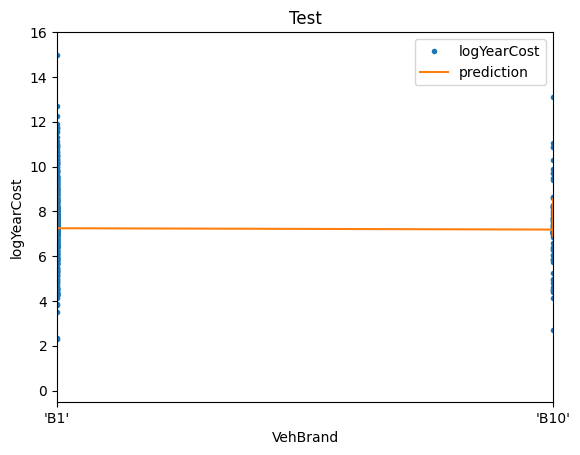

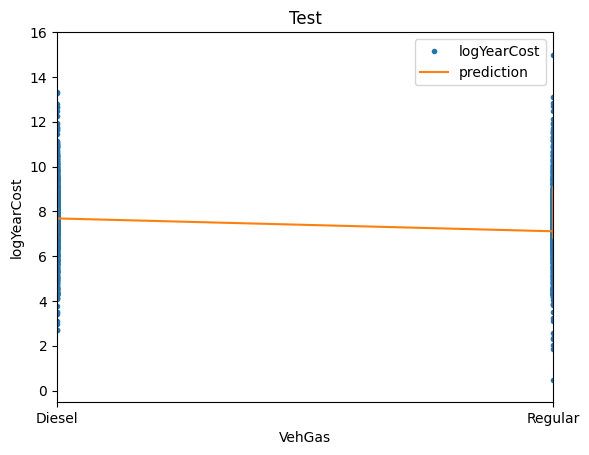

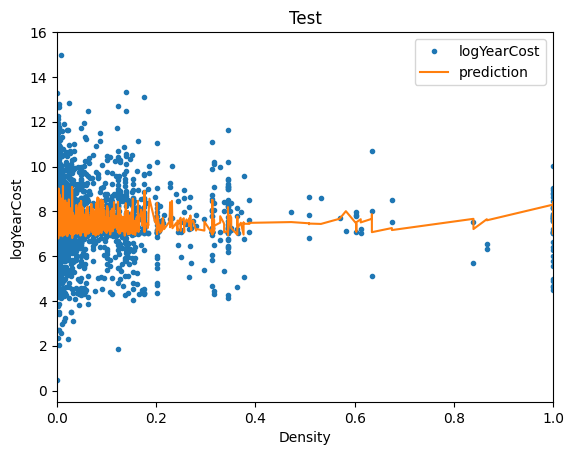

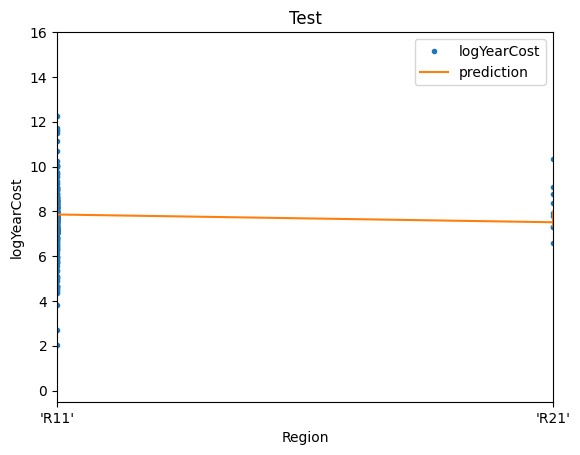

In [38]:
# Plot dependencies over all variables one-by-one
if 1:
    fold = 0
    ylim = [-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5]
    xlim = [0, 1]
    sort_by_pred = True
    for col in X_df.columns:
        for fold_i, (train_i, test_i) in enumerate(
            cv_iterator.split(X_df, y_df)
        ):
            if fold_i==fold:
                fig_test, ax_test = plt.subplots()
                plot_regression(
                    X_df, 
                    y_df, 
                    fold_i, 
                    test_i, 
                    cv_results, 
                    ax_test, 
                    sort_by_pred=sort_by_pred, 
                    col=col, 
                    ylabel='logYearCost', 
                    xlim=xlim, 
                    ylim=ylim, 
                    title='Test', 
                )        

In a previous commit, I wasn't calculating the yearly cost but trying to fit the raw claims levels. This wasn't working and the following attempt was made. Now it seems like the model is going something reasonable but let's see if we can squeeze a little more juice from it by carrying out the analysis below again.

## fast.ai model and latent embedding of categorical variables
This should make the model more expressive so maybe it can still be improved. The primary purpose here is for feature engineering of the categorical variables. However, there is the side effect that another model will be tried here that can also be compared.

### Preprocess

In [39]:
# Make middle thresholds equal to erase their effect
REMOVE_BANDS = 0
log_claim_low_thresh = 0
log_claim_med1_thresh = 4.1 if REMOVE_BANDS else 4.4
log_claim_med2_thresh = 4.7 if REMOVE_BANDS else 4.4
log_claim_med3_thresh = 6.9 if REMOVE_BANDS else 7
log_claim_med4_thresh = 7.1 if REMOVE_BANDS else 7
log_claim_high_thresh = 15.5

In [40]:
X_y_df = pd.concat([X_df, y_df], axis=1)
X_y_df

,ClaimNb,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,logYearCost
IDpol,,,,,,,,,,,
139.0,0.000000,'F',0.272727,0.010101,0.530864,0.000000,'B12',Regular,1.000000,'R11',6.001415
190.0,0.000000,'B',0.727273,0.050505,0.395062,0.056180,'B12',Diesel,0.002000,'R25',9.557894
414.0,0.000000,'E',0.000000,0.000000,0.222222,0.196629,'B12',Regular,0.177421,'R11',9.249939
424.0,0.066667,'F',0.545455,0.000000,0.407407,0.280899,'B12',Regular,1.000000,'R11',9.768480
463.0,0.000000,'A',0.090909,0.000000,0.333333,0.000000,'B12',Regular,0.000370,'R73',9.461895
...,...,...,...,...,...,...,...,...,...,...,...
6113521.0,0.000000,'C',0.000000,0.010101,0.098765,0.056180,'B12',Diesel,0.011445,'R82',8.903513
6113793.0,0.000000,'C',0.272727,0.020202,0.407407,0.000000,'B12',Diesel,0.006519,'R72',9.444780
6113817.0,0.000000,'D',0.000000,0.000000,0.209877,0.005618,'B12',Regular,0.063597,'R82',8.933020


In [41]:
sample_select = (
    (
        (
            X_y_df['logYearCost'] 
            > log_claim_low_thresh
        )
        & (
            X_y_df['logYearCost'] 
            <= log_claim_med1_thresh
        )
    ) 
    | (
        (
            X_y_df['logYearCost'] 
            > log_claim_med2_thresh
        )
        & (
            X_y_df['logYearCost'] 
            <= log_claim_med3_thresh
        )
    )
    | (
        (
            X_y_df['logYearCost'] 
            > log_claim_med4_thresh
        )
        & (
            X_y_df['logYearCost'] 
            <= log_claim_high_thresh
        )
    )
)

In [42]:
X_y_df = X_y_df.loc[sample_select, :]

In [43]:
cont_vars, cat_vars = fai.cont_cat_split(X_y_df, dep_var='logYearCost')

In [44]:
X_y_df.loc[:, cat_vars] = X_y_df.loc[:, cat_vars].astype(str)
X_y_df = X_y_df.reset_index(drop=True)
X_y_df

,ClaimNb,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,logYearCost
0,0.000000,'F',0.272727,0.010101,0.530864,0.000000,'B12',Regular,1.000000,'R11',6.001415
1,0.000000,'B',0.727273,0.050505,0.395062,0.056180,'B12',Diesel,0.002000,'R25',9.557894
2,0.000000,'E',0.000000,0.000000,0.222222,0.196629,'B12',Regular,0.177421,'R11',9.249939
3,0.066667,'F',0.545455,0.000000,0.407407,0.280899,'B12',Regular,1.000000,'R11',9.768480
4,0.000000,'A',0.090909,0.000000,0.333333,0.000000,'B12',Regular,0.000370,'R73',9.461895
...,...,...,...,...,...,...,...,...,...,...,...
24935,0.000000,'C',0.000000,0.010101,0.098765,0.056180,'B12',Diesel,0.011445,'R82',8.903513
24936,0.000000,'C',0.272727,0.020202,0.407407,0.000000,'B12',Diesel,0.006519,'R72',9.444780
24937,0.000000,'D',0.000000,0.000000,0.209877,0.005618,'B12',Regular,0.063597,'R82',8.933020
24938,0.066667,'C',1.000000,0.030303,0.222222,0.000000,'B12',Regular,0.006630,'R54',11.183637


### Fit model

In [45]:
splits = fai.RandomSplitter(valid_pct=0.2)(fai.range_of(X_y_df))
to = fai.TabularPandas(
    X_y_df, 
    procs=[fai.Categorify, fai.Normalize],
    cat_names=cat_vars,
    cont_names=cont_vars,
    y_names='logYearCost',
    splits=splits, 
)
dls = to.dataloaders(bs=64)

Again the mean absolute error is chosen here for robustness against outliers.

In [46]:
learn = fai.tabular_learner(dls, metrics=fai.mae)
early_stop_cb = fai.EarlyStoppingCallback(patience=2)

In [47]:
def fit_one_cycle(learn):
    learn.fit_one_cycle(10, cbs=early_stop_cb)
    return learn
learn = fit_one_cycle(learn)

epoch,train_loss,valid_loss,mae,time
0,54.266045,51.819584,7.061909,00:04
1,6.557763,2.525586,1.187975,00:03
2,2.158641,2.075005,1.035056,00:03
3,2.107105,2.197706,1.060073,00:03
4,1.955019,1.962028,0.983549,00:03
5,2.353369,2.139035,1.056244,00:03
6,2.038023,1.915720,0.971092,00:03
7,2.017574,1.932119,0.960176,00:03
8,1.968345,1.865695,0.950350,00:03
9,1.967790,1.854722,0.942734,00:03


### Inspect results

In [48]:
preds_train, targs_train = learn.get_preds(dl=dls.train)

In [49]:
preds_test, targs_test = learn.get_preds(dl=dls.valid)

In [50]:
def plot_fastai_regression(
        preds, 
        targs, 
        ax,  
        sort_by_pred=True, 
        **kwargs, 
    ):
    y_pred_df = pd.DataFrame(
        preds, 
        columns=['prediction'], 
    )
    y_data_df = pd.DataFrame(
        targs, 
        columns=['logYearCost'], 
    )
    y_df = pd.concat([y_data_df, y_pred_df], axis=1)
    sort_col = 'prediction' if sort_by_pred else 'logYearCost'
    y_df = y_df.sort_values(sort_col)
    ax.plot(
        y_df['logYearCost'].to_numpy(), 
        marker='.',
        linestyle='', 
        label='logYearCost', 
    )
    ax.plot(y_df['prediction'].to_numpy(), label='prediction')
    ax.legend()
    _ = ax.set(**kwargs)

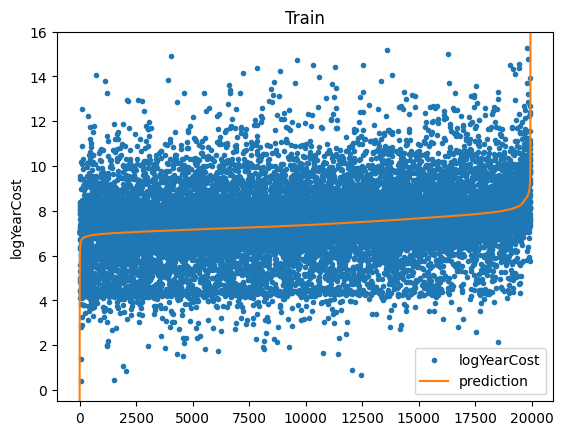

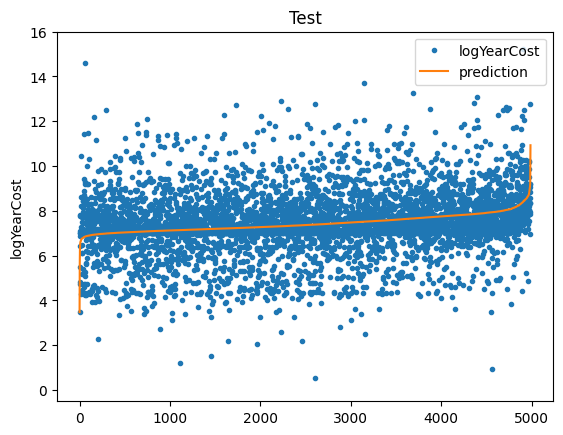

In [51]:
ylim = [-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5]
sort_by_pred = True
fig_train, ax_train = plt.subplots()
plot_fastai_regression(
    preds_train, 
    targs_train, 
    ax_train, 
    sort_by_pred=sort_by_pred, 
    ylabel='logYearCost', 
    ylim=ylim, 
    title='Train', 
)
fig_test, ax_test = plt.subplots()
plot_fastai_regression(
    preds_test, 
    targs_test, 
    ax_test, 
    sort_by_pred=sort_by_pred, 
    ylabel='logYearCost', 
    ylim=ylim, 
    title='Test', 
)        

In [52]:
def calc_rmse(preds, targs):
    return np.sqrt(((preds - targs) ** 2).mean())

In [53]:
print(
    "Training RMSE ="
    f" {calc_rmse(preds_train, targs_train).item()}"
)
print(
    "Test RMSE ="
    f" {calc_rmse(preds_test, targs_test).item()}"
)

Training RMSE = 1.3998875617980957
Test RMSE = 1.361881971359253


RMSE decreases for this model. Let's see how the XGBoost performs now if we use the embeddings generated from the fast.ai model.

### Extract embeddings and insert back into feature matrix

In [54]:
embs = [param for param in learn.model.embeds.parameters()]
cat = to.procs.categorify

In [55]:
def emb2df(emb, feature, cat):
    return pd.DataFrame(
        emb, 
        index=cat, 
        columns=[
            f'{feature}_emb_{i}' for i in range(emb.shape[1])
        ]
    ).reset_index().rename({'index': feature}, axis=1)

In [56]:
X_y_emb_df = log_claim_cont_cat_nonull_df.copy()
for i_feat, feature in enumerate(list(cat.classes.keys())):
    X_y_emb_df = pd.merge(
        X_y_emb_df, 
        emb2df(embs[i_feat].detach().cpu().numpy(), feature, cat[feature]), 
        how='left', 
        on=feature, 
    ).drop(feature, axis=1)

In [57]:
X_y_emb_df

,IDpol,ClaimNb,VehPower,VehAge,DrivAge,BonusMalus,Density,logYearCost,Area_emb_0,Area_emb_1,...,VehGas_emb_2,Region_emb_0,Region_emb_1,Region_emb_2,Region_emb_3,Region_emb_4,Region_emb_5,Region_emb_6,Region_emb_7,Region_emb_8
0,139.0,1.0,7.0,1.0,61.0,50.0,27000.0,6.001415,-0.025840,0.003586,...,-0.011230,-0.004332,-0.005089,-0.003126,-0.018136,0.006759,0.016358,-0.009782,-0.001286,-0.020171
1,190.0,1.0,12.0,5.0,50.0,60.0,56.0,9.557894,0.004105,0.005544,...,-0.014633,0.003301,0.019240,0.028193,0.005969,-0.003739,-0.026402,-0.019117,-0.021049,-0.053018
2,414.0,1.0,4.0,0.0,36.0,85.0,4792.0,9.249939,-0.023675,0.010677,...,-0.011230,-0.004332,-0.005089,-0.003126,-0.018136,0.006759,0.016358,-0.009782,-0.001286,-0.020171
3,424.0,2.0,10.0,0.0,51.0,100.0,27000.0,9.768480,-0.025840,0.003586,...,-0.011230,-0.004332,-0.005089,-0.003126,-0.018136,0.006759,0.016358,-0.009782,-0.001286,-0.020171
4,463.0,1.0,5.0,0.0,45.0,50.0,12.0,9.461895,0.000664,0.011569,...,-0.011230,0.008245,-0.008805,-0.019718,-0.007076,-0.046932,0.043760,0.033784,-0.031743,-0.006191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24939,6113521.0,1.0,4.0,1.0,26.0,60.0,311.0,8.903513,-0.004871,0.000536,...,-0.014633,-0.011320,0.001563,0.009355,0.033079,0.000627,0.001766,-0.026948,0.037197,0.004246
24940,6113793.0,1.0,7.0,2.0,51.0,50.0,178.0,9.444780,-0.004871,0.000536,...,-0.014633,-0.000907,-0.024091,-0.032702,-0.002819,0.028497,-0.039141,-0.012335,0.039143,0.030639
24941,6113817.0,1.0,4.0,0.0,35.0,51.0,1719.0,8.933020,-0.004401,-0.013010,...,-0.011230,-0.011320,0.001563,0.009355,0.033079,0.000627,0.001766,-0.026948,0.037197,0.004246
24942,6113834.0,2.0,15.0,3.0,36.0,50.0,181.0,11.183637,-0.004871,0.000536,...,-0.011230,-0.006289,0.011019,0.016984,0.010835,0.038622,0.021727,-0.021080,-0.035285,0.007537


## XGBoost with embedded categorical features
This time, we'll also fit without the strong bands because I believe that this is the path to providing a more fair prediction. At least the the models tried so far.

### Prepare fitting inputs

In [58]:
# Make middle thresholds equal to erase their effect
REMOVE_BANDS = 0
log_claim_low_thresh = 0
log_claim_med1_thresh = 4.1 if REMOVE_BANDS else 4.4
log_claim_med2_thresh = 4.7 if REMOVE_BANDS else 4.4
log_claim_med3_thresh = 6.9 if REMOVE_BANDS else 7
log_claim_med4_thresh = 7.1 if REMOVE_BANDS else 7
log_claim_high_thresh = 15.5

In [59]:
sample_select = (
    (
        (
            X_y_emb_df['logYearCost'] 
            > log_claim_low_thresh
        )
        & (
            X_y_emb_df['logYearCost'] 
            <= log_claim_med1_thresh
        )
    ) 
    | (
        (
            X_y_emb_df['logYearCost'] 
            > log_claim_med2_thresh
        )
        & (
            X_y_emb_df['logYearCost'] 
            <= log_claim_med3_thresh
        )
    )
    | (
        (
            X_y_emb_df['logYearCost'] 
            > log_claim_med4_thresh
        )
        & (
            X_y_emb_df['logYearCost'] 
            <= log_claim_high_thresh
        )
    )
)

In [60]:
scaler = MinMaxScaler()
features_nonull_df = (
    X_y_emb_df
        .loc[sample_select, :]
        .set_index('IDpol')
        .drop('logYearCost', axis=1)
)
features_nonull = scaler.fit_transform(features_nonull_df)
features_nonull_df = pd.DataFrame(
    features_nonull, 
    columns=features_nonull_df.columns, 
    index=features_nonull_df.index, 
)
features_nonull_df

,ClaimNb,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_emb_0,Area_emb_1,Area_emb_2,Area_emb_3,...,VehGas_emb_2,Region_emb_0,Region_emb_1,Region_emb_2,Region_emb_3,Region_emb_4,Region_emb_5,Region_emb_6,Region_emb_7,Region_emb_8
IDpol,,,,,,,,,,,,,,,,,,,,,
139.0,0.000000,0.272727,0.010101,0.530864,0.000000,1.000000,0.000000,0.675211,0.000000,0.930520,...,1.0,0.693554,0.564659,0.724509,0.556319,0.429682,0.753146,0.337453,0.247475,0.268618
190.0,0.000000,0.727273,0.050505,0.395062,0.056180,0.002000,1.000000,0.754842,0.121191,0.000000,...,0.0,0.756736,0.728916,0.972500,0.744345,0.370089,0.367930,0.240663,0.103625,0.000000
414.0,0.000000,0.000000,0.000000,0.222222,0.196629,0.177421,0.072281,0.963702,1.000000,1.000000,...,1.0,0.693554,0.564659,0.724509,0.556319,0.429682,0.753146,0.337453,0.247475,0.268618
424.0,0.066667,0.545455,0.000000,0.407407,0.280899,1.000000,0.000000,0.675211,0.000000,0.930520,...,1.0,0.693554,0.564659,0.724509,0.556319,0.429682,0.753146,0.337453,0.247475,0.268618
463.0,0.000000,0.090909,0.000000,0.333333,0.000000,0.000370,0.885109,1.000000,0.104189,0.270931,...,1.0,0.797657,0.539565,0.593129,0.642594,0.124896,1.000000,0.789174,0.025787,0.382949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6113521.0,0.000000,0.000000,0.010101,0.098765,0.056180,0.011445,0.700256,0.551088,0.204018,0.469511,...,0.0,0.635710,0.609566,0.823333,0.955800,0.394876,0.621687,0.159469,0.527590,0.468302
6113793.0,0.000000,0.272727,0.020202,0.407407,0.000000,0.006519,0.700256,0.551088,0.204018,0.469511,...,0.0,0.721908,0.436359,0.490324,0.675798,0.553087,0.253168,0.310981,0.541755,0.684136
6113817.0,0.000000,0.000000,0.000000,0.209877,0.005618,0.063597,0.715947,0.000000,0.580918,0.483367,...,1.0,0.635710,0.609566,0.823333,0.955800,0.394876,0.621687,0.159469,0.527590,0.468302


In [61]:
log_claim_amount_nonull_df = (
    X_y_emb_df[['IDpol', 'logYearCost']]
        .loc[sample_select, :]
        .set_index('IDpol')
)
log_claim_amount_nonull_df

,logYearCost
IDpol,
139.0,6.001415
190.0,9.557894
414.0,9.249939
424.0,9.768480
463.0,9.461895
...,...
6113521.0,8.903513
6113793.0,9.444780
6113817.0,8.933020


### Setup model

In [62]:
X_df = features_nonull_df
y_df = log_claim_amount_nonull_df

In [63]:
objective = 'reg:absoluteerror'
eval_metric = 'rmse'
enable_categorical = False

In [64]:
model = XGBRegressor(
    n_estimators=100, 
    eta=0.3, # 0.3
    gamma=1, # 0
    max_depth=6, # 6
    max_leaves=10, 
    min_child_weight=20, # 1
    subsample=0.5, # 1
    reg_lambda=10, # 1 (L2)
    reg_alpha=2, # 0 (L1)
    grow_policy='depthwise', # depthwise
    tree_method='hist', # auto
    max_bin=16, # 256
    random_state=0, 
    enable_categorical=enable_categorical, 
    objective=objective, 
    eval_metric=eval_metric, 
)

### Cross-validation

In [65]:
cv_iterator = KFold(
    n_splits=10, 
    shuffle=True, 
    random_state=0, 
)

In [66]:
cv_results = cross_validate(
    model, 
    X_df, 
    y_df, 
    scoring=[
        'neg_root_mean_squared_error', 
        'neg_median_absolute_error', 
    ], 
    cv=cv_iterator, 
    return_estimator=True, 
)

In [67]:
print(
    "Average test_neg_root_mean_squared_error"
    f" = {cv_results['test_neg_root_mean_squared_error'].mean()}"
)
print(
    "Average test_neg_median_absolute_error"
    f" = {cv_results['test_neg_median_absolute_error'].mean()}"
)

Average test_neg_root_mean_squared_error = -1.386177282825306
Average test_neg_median_absolute_error = -0.5807133755238703


Very little difference here compared to the previous values: </br>
Average test_neg_root_mean_squared_error = -1.3867217912830683 </br>
Average test_neg_median_absolute_error = -0.5768223243107388

### Plot results

In [68]:
def exp_plot_regression(
        X_df, 
        y_df, 
        fold, 
        i_data, 
        cv_results,
        ax,  
        sort_by_pred=True, 
        col=None, 
        **kwargs, 
    ):
    X_data_df = X_df.iloc[i_data]
    y_pred_df = pd.DataFrame(
        cv_results['estimator'][fold]
            .predict(X_data_df)
            .flatten(), 
        columns=['prediction'], 
        index=X_data_df.index
    )
    y_data_df = y_df.iloc[i_data]
    y_fold_df = pd.concat([y_data_df, y_pred_df], axis=1)
    X_y_fold_df = pd.concat([X_data_df, y_fold_df], axis=1)
    sort_col = 'prediction' if sort_by_pred else 'logYearCost'
    if col is None:
        y_fold_df = y_fold_df.sort_values(sort_col)
        ax.plot(
            np.exp(y_fold_df['logYearCost'].to_numpy()), 
            marker='.',
            linestyle='', 
            label='YearCost', 
        )
        ax.plot(np.exp(y_fold_df['prediction'].to_numpy()), label='lin. pred.')
    else:
        X_y_fold_df = X_y_fold_df.sort_values(col)
        ax.plot(
            X_y_fold_df[col].to_numpy(), 
            np.exp(X_y_fold_df['logYearCost'].to_numpy()), 
            marker='.',
            linestyle='', 
            label='YearCost', 
        )
        ax.plot(
            X_y_fold_df[col].to_numpy(), 
            np.exp(X_y_fold_df['prediction'].to_numpy()), 
            label='lin. pred.'
        )
        ax.set_xlabel(col)
    ax.legend()
    _ = ax.set(**kwargs)

This time plot back in linear space (not log)

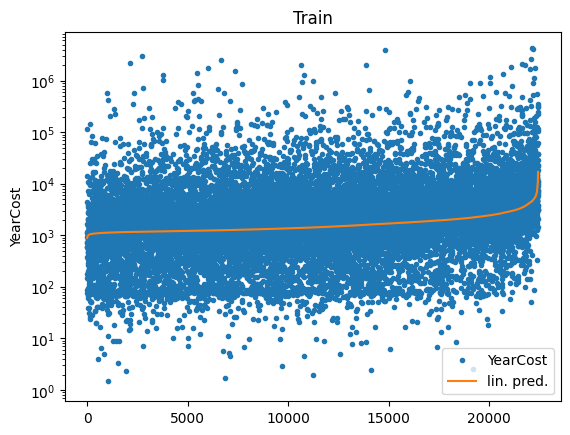

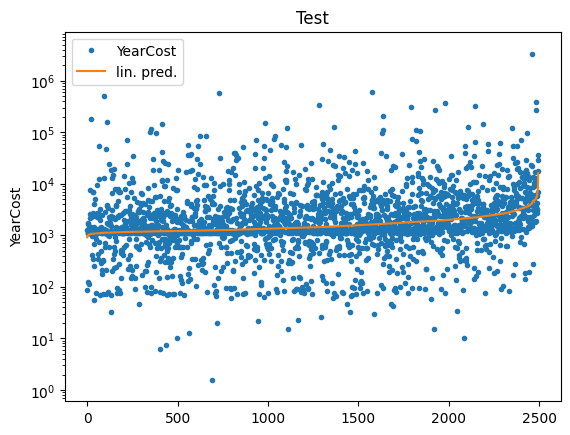

In [69]:
fold = 0
ylim = np.exp(
    np.array([-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5])
)
yscale = 'log'
sort_by_pred = True
for fold_i, (train_i, test_i) in enumerate(
    cv_iterator.split(X_df, y_df)
):
    if fold_i==fold:
        fig_train, ax_train = plt.subplots()
        exp_plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            train_i, 
            cv_results, 
            ax_train, 
            sort_by_pred=sort_by_pred, 
            ylabel='YearCost', 
            ylim=ylim, 
            yscale=yscale, 
            title='Train', 
        )
        fig_test, ax_test = plt.subplots()
        exp_plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            test_i, 
            cv_results, 
            ax_test, 
            sort_by_pred=sort_by_pred, 
            ylabel='YearCost', 
            ylim=ylim, 
            yscale=yscale, 
            title='Test', 
        )        

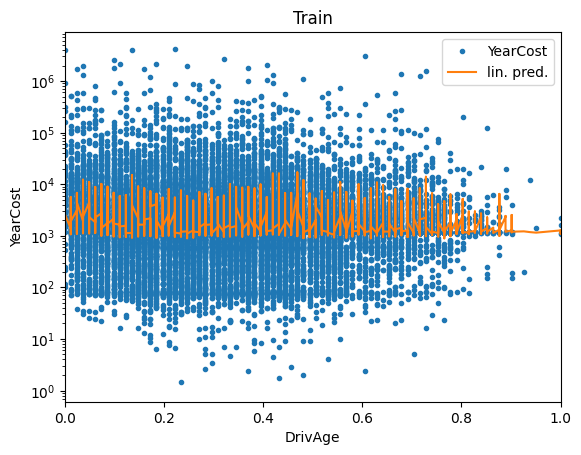

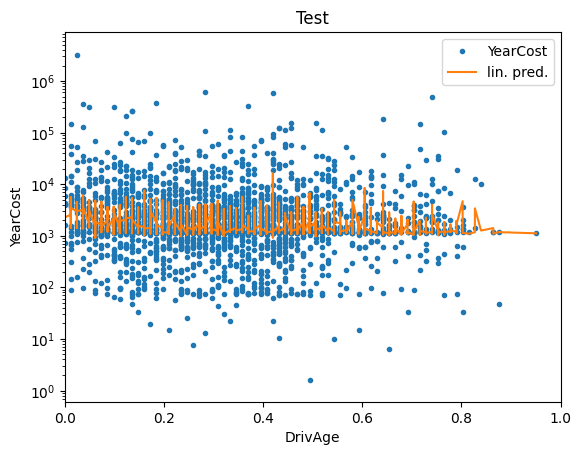

In [70]:
fold = 0
ylim = np.exp(
    np.array([-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5])
)
yscale = 'log'
xlim = [0, 1]
sort_by_pred = True
col = "DrivAge"
for fold_i, (train_i, test_i) in enumerate(
    cv_iterator.split(X_df, y_df)
):
    if fold_i==fold:
        fig_train, ax_train = plt.subplots()
        exp_plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            train_i, 
            cv_results, 
            ax_train, 
            sort_by_pred=sort_by_pred, 
            col=col, 
            ylabel='YearCost', 
            ylim=ylim, 
            xlim=xlim, 
            yscale=yscale, 
            title='Train', 
        )
        fig_test, ax_test = plt.subplots()
        exp_plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            test_i, 
            cv_results, 
            ax_test, 
            sort_by_pred=sort_by_pred, 
            col=col, 
            ylabel='YearCost', 
            ylim=ylim, 
            xlim=xlim, 
            yscale=yscale, 
            title='Test', 
        )        

## Feature importances
Just quickly calculate feature importances to see which features contributed the most to the model.

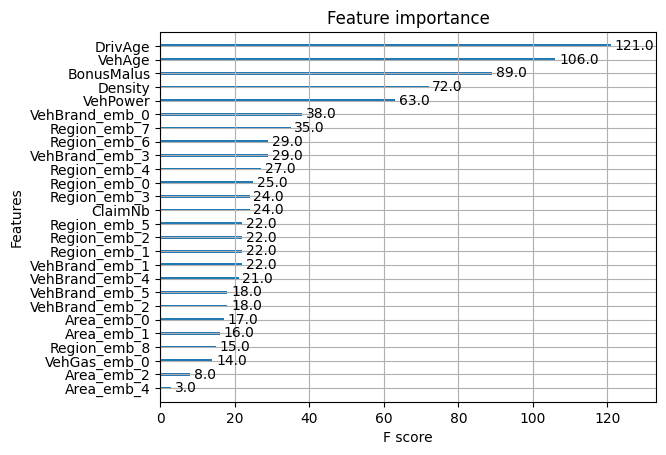

In [85]:
from xgboost import plot_importance
model = cv_results['estimator'][0]
ax = plot_importance(model, max_num_features=30)

## Final statistics on insurance pricing
Before anyone balks at the idea of the average person paying something like 1200 euros/year in car insurance, it is probably wise to mention that we were only using these numbers as a proxy for risk. We should remember that we through out a ton of samples where the insurance company pays nothing. It is this cost sharing that is the reason why insurance exists. Let's bring that back in.

The preceding work was analyzed from a population of size:

In [71]:
n_costly_people = len(X_y_df)
n_costly_people

24940

The total number of customers is actuall:

In [72]:
n_customers = len(freq_df)
n_customers

678013

Thus each person's claim from above on average gets shared with the following number of people:

In [73]:
cost_share = n_customers/n_costly_people
cost_share

27.18576583801123

Adding these factors after converting back to linear space gives us the amount that the customers should be paying just to make up the claims costs (we'll just use the data from the first model above since there wasn't much difference and the dataframe is already handy). Of course this will be higher because the operational costs of the insurer need to be added.

In [74]:
(
    X_y_test0_df
        .assign(YearSharedCost=np.exp(X_y_test0_df['logYearCost'])/cost_share)
        .loc[:, 'YearSharedCost']
        .describe()
)

count      2494.000000
mean        286.889595
std        2625.419266
min           0.058486
25%          41.496716
50%          55.270251
75%         128.357404
max      120119.761951
Name: YearSharedCost, dtype: float64

That's a nice one. 120k euros/year + operational fees for car insurance. Poor guy. 

Thanks for the opportunity! Hope you had fun walking through this. It was a fun exercise!

jon

# End